In [1]:
import os
from zipfile import ZipFile
from urllib.request import urlretrieve

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = '/content/drive/MyDrive'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://drive.google.com/drive/folders/1-5drKSqOYxJ1Z1GI61SUBy_5mEa6JC-M?usp=drive_link"
asset_zip_path = os.path.join(os.getcwd(), "/content/drive/MyDrive/cropped_images.zip")

# Download if asset ZIP does not exist.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

Invalid file. File is not a zip file


In [5]:
asset_zip_path = os.path.join(os.getcwd(), "/content/drive/MyDrive/cropped_images-20241205T091830Z-001.zip")

In [6]:
if not os.path.exists('/content/drive/MyDrive/cropped_images'):
    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(asset_zip_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(asset_zip_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)


Done


In [7]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/scut_data/seq2seq_model_printed/checkpoint-750').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

In [8]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test', '*'),
    output_file="ocr_results.txt",
    num_samples=50
):
    image_paths = glob.glob(data_path)
    with open(output_file, 'w') as file:
        file.write("Filename\tExtracted Text\n")  # Header for the output file
        for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
            if i == num_samples:
                break
            image = read_and_show(image_path)
            text = ocr(image, processor, trained_model)
            file_name = os.path.basename(image_path)
            file.write(f"{file_name}\t{text}\n")  # Write filename and text to the file
            plt.figure(figsize=(7, 4))
            plt.imshow(image)
            plt.title(text)
            plt.axis('off')
            plt.show()

# Ensure `processor` and `trained_model` are defined before running eval_new_data.


  0%|          | 0/223 [00:00<?, ?it/s]

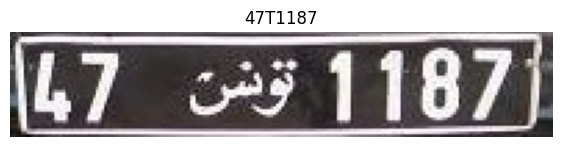

  0%|          | 1/223 [00:02<07:55,  2.14s/it]

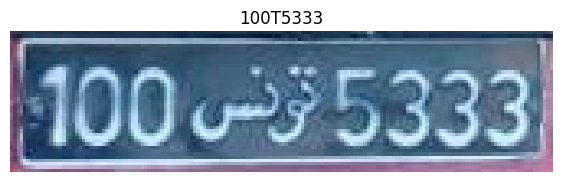

  1%|          | 2/223 [00:02<03:40,  1.00it/s]

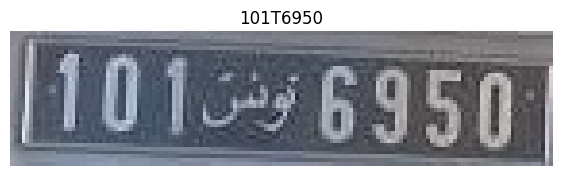

  1%|▏         | 3/223 [00:02<02:20,  1.57it/s]

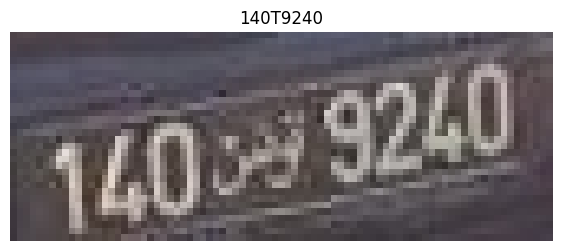

  2%|▏         | 4/223 [00:02<01:49,  2.00it/s]

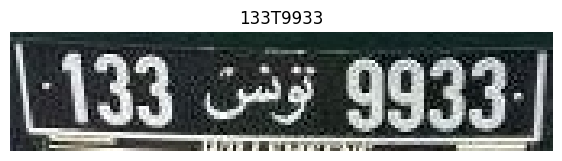

  2%|▏         | 5/223 [00:03<01:32,  2.37it/s]

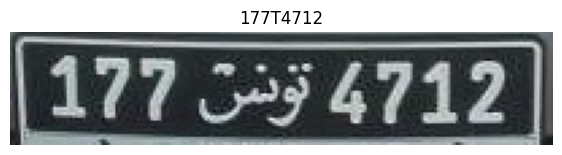

  3%|▎         | 6/223 [00:03<01:21,  2.68it/s]

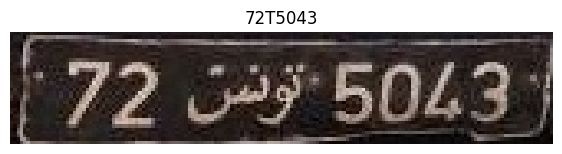

  3%|▎         | 7/223 [00:03<01:14,  2.88it/s]

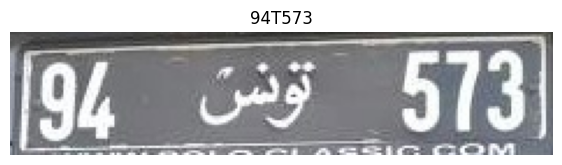

  4%|▎         | 8/223 [00:04<01:13,  2.94it/s]

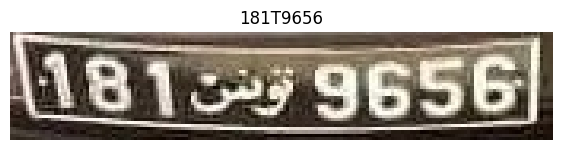

  4%|▍         | 9/223 [00:04<01:08,  3.12it/s]

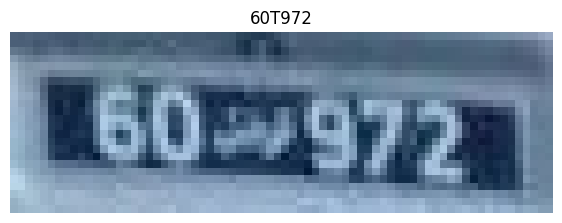

  4%|▍         | 10/223 [00:04<01:06,  3.18it/s]

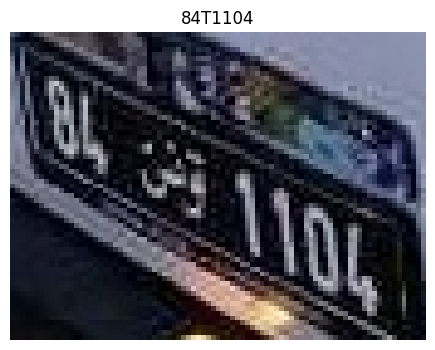

  5%|▍         | 11/223 [00:04<01:00,  3.49it/s]

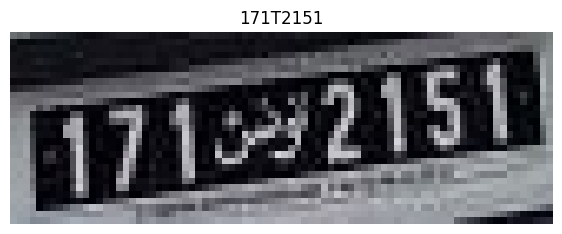

  5%|▌         | 12/223 [00:05<01:00,  3.47it/s]

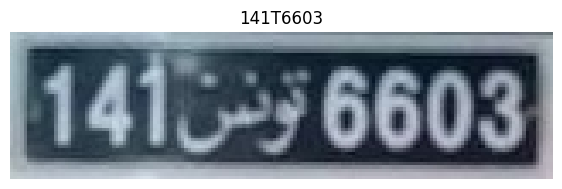

  6%|▌         | 13/223 [00:05<01:02,  3.38it/s]

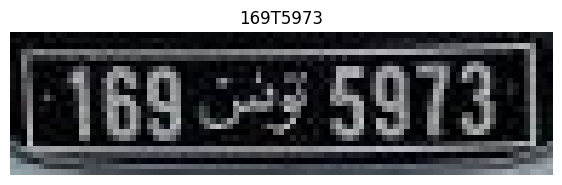

  6%|▋         | 14/223 [00:05<00:58,  3.57it/s]

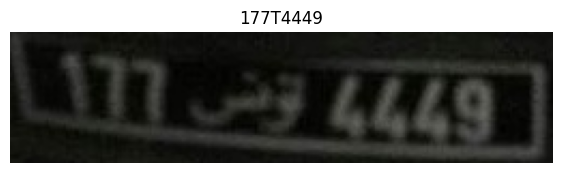

  7%|▋         | 15/223 [00:06<01:01,  3.38it/s]

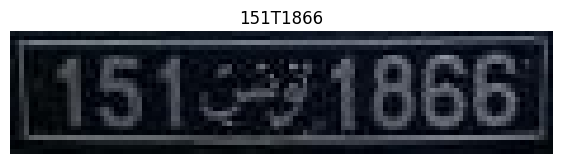

  7%|▋         | 16/223 [00:06<01:01,  3.37it/s]

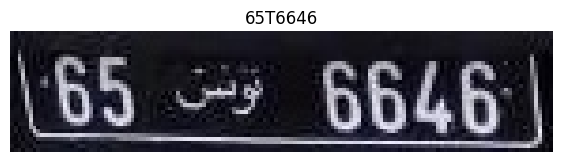

  8%|▊         | 17/223 [00:06<01:00,  3.40it/s]

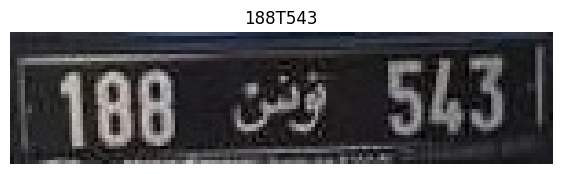

  8%|▊         | 18/223 [00:06<01:02,  3.27it/s]

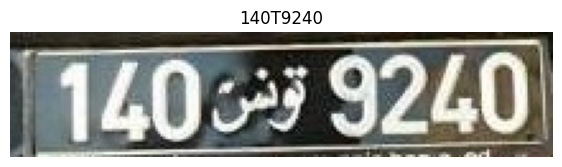

  9%|▊         | 19/223 [00:07<01:04,  3.15it/s]

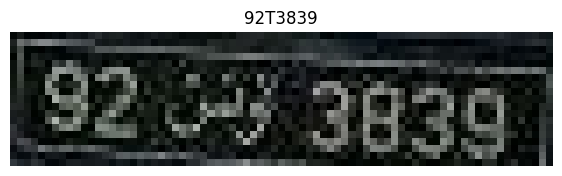

  9%|▉         | 20/223 [00:07<01:00,  3.33it/s]

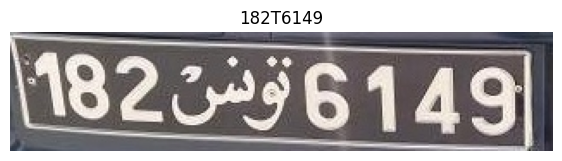

  9%|▉         | 21/223 [00:07<01:04,  3.12it/s]

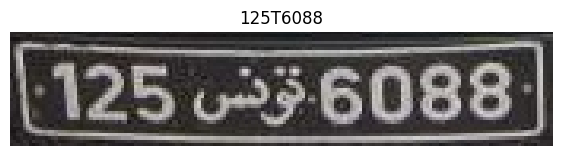

 10%|▉         | 22/223 [00:08<00:57,  3.48it/s]

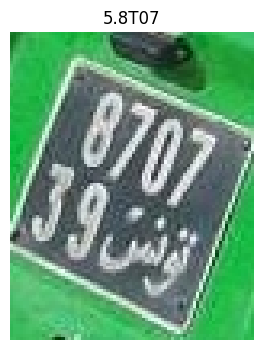

 10%|█         | 23/223 [00:08<00:52,  3.84it/s]

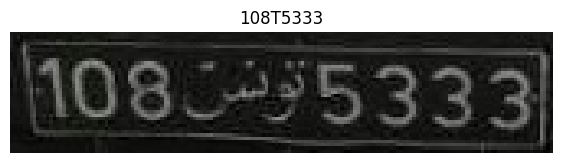

 11%|█         | 24/223 [00:08<00:48,  4.12it/s]

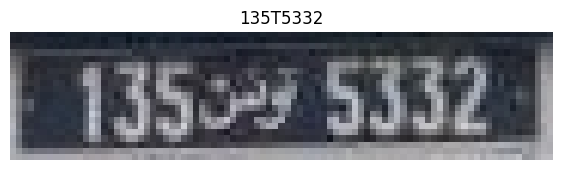

 11%|█         | 25/223 [00:08<00:43,  4.50it/s]

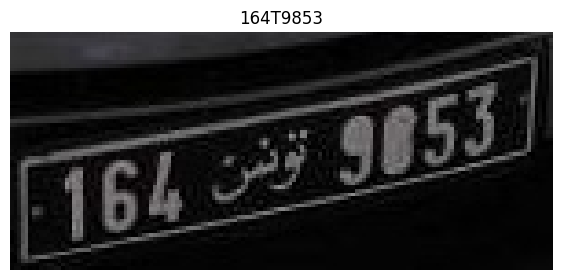

 12%|█▏        | 26/223 [00:08<00:44,  4.42it/s]

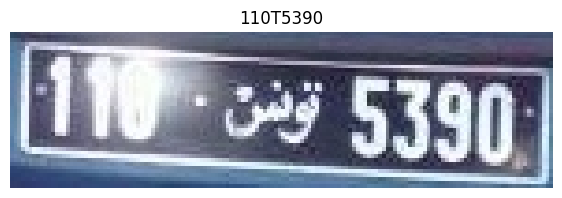

 12%|█▏        | 27/223 [00:09<00:43,  4.49it/s]

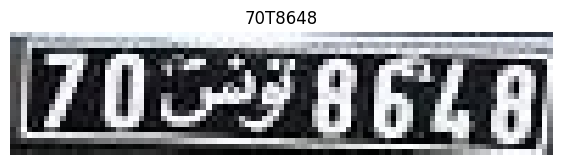

 13%|█▎        | 28/223 [00:09<00:42,  4.63it/s]

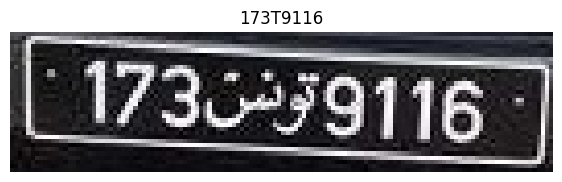

 13%|█▎        | 29/223 [00:09<00:41,  4.72it/s]

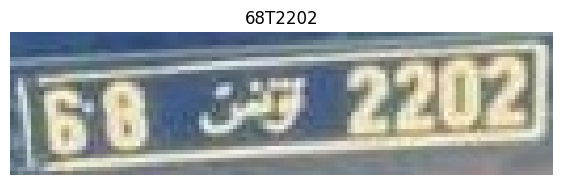

 13%|█▎        | 30/223 [00:09<00:40,  4.73it/s]

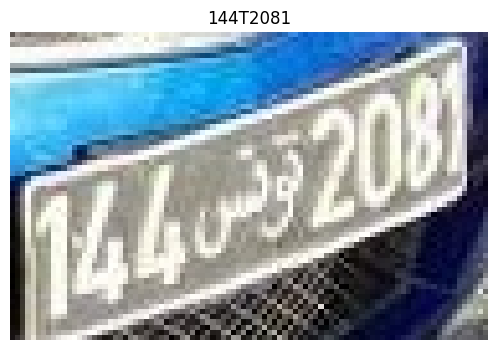

 14%|█▍        | 31/223 [00:09<00:40,  4.70it/s]

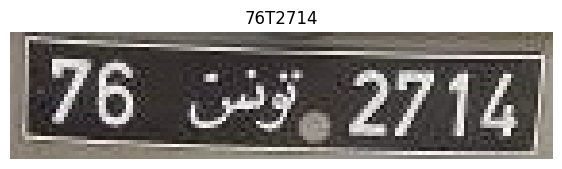

 14%|█▍        | 32/223 [00:10<00:39,  4.79it/s]

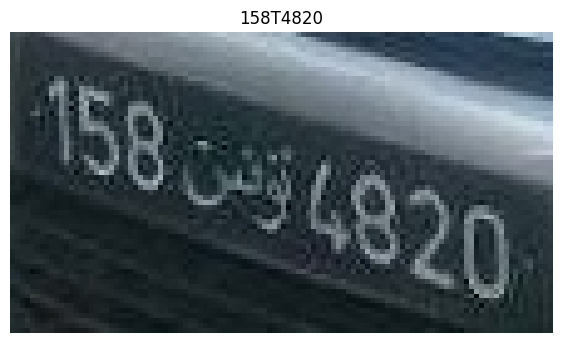

 15%|█▍        | 33/223 [00:10<00:40,  4.66it/s]

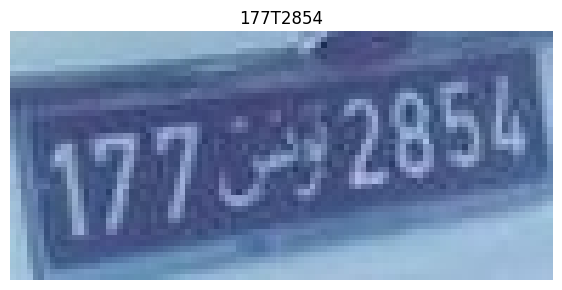

 15%|█▌        | 34/223 [00:10<00:40,  4.70it/s]

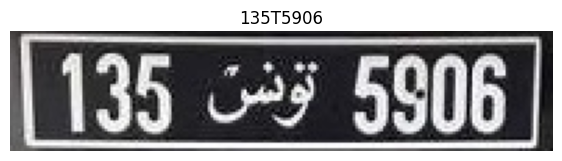

 16%|█▌        | 35/223 [00:10<00:41,  4.50it/s]

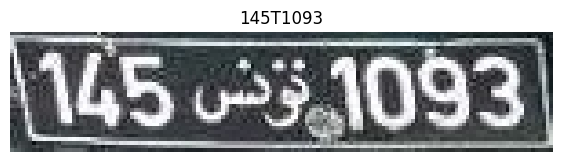

 16%|█▌        | 36/223 [00:11<00:39,  4.71it/s]

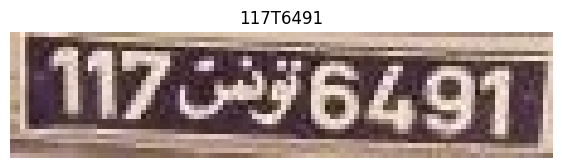

 17%|█▋        | 37/223 [00:11<00:39,  4.77it/s]

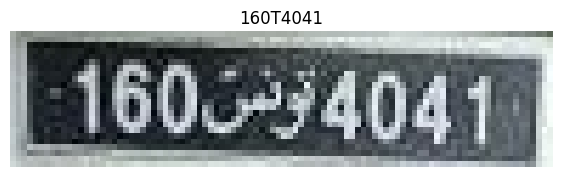

 17%|█▋        | 38/223 [00:11<00:37,  4.89it/s]

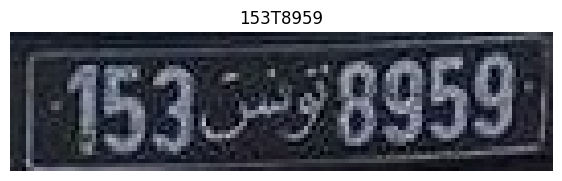

 17%|█▋        | 39/223 [00:11<00:36,  5.01it/s]

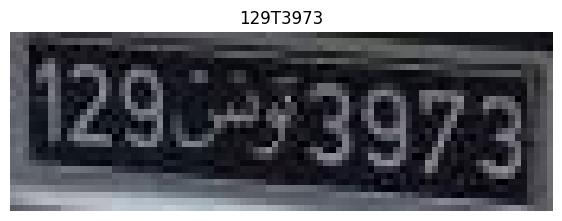

 18%|█▊        | 40/223 [00:11<00:38,  4.72it/s]

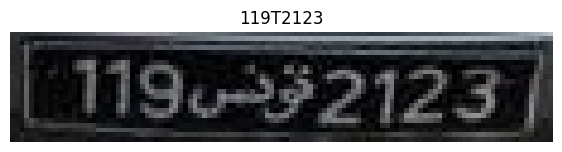

 18%|█▊        | 41/223 [00:12<00:37,  4.90it/s]

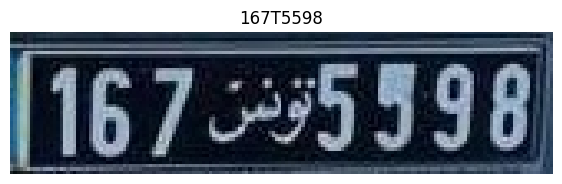

 19%|█▉        | 42/223 [00:12<00:36,  4.90it/s]

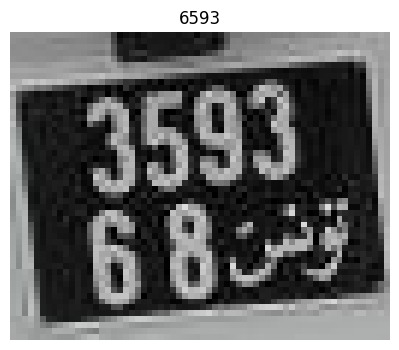

 19%|█▉        | 43/223 [00:12<00:36,  4.95it/s]

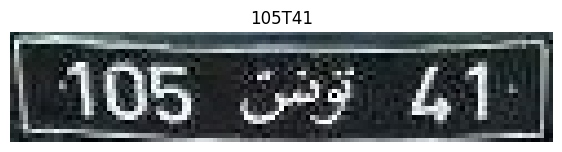

 20%|█▉        | 44/223 [00:12<00:35,  5.10it/s]

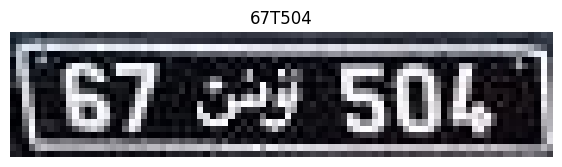

 20%|██        | 45/223 [00:12<00:35,  5.06it/s]

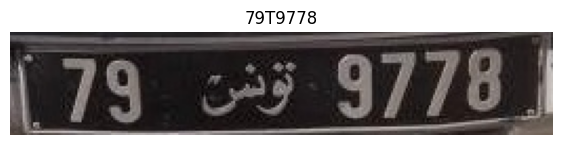

 21%|██        | 46/223 [00:13<00:37,  4.72it/s]

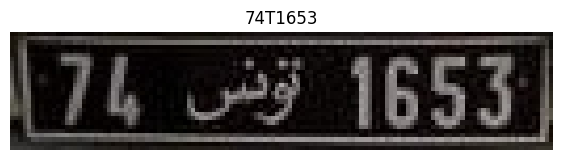

 21%|██        | 47/223 [00:13<00:36,  4.87it/s]

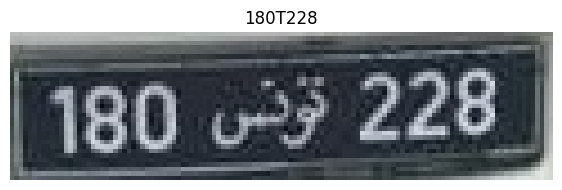

 22%|██▏       | 48/223 [00:13<00:35,  4.93it/s]

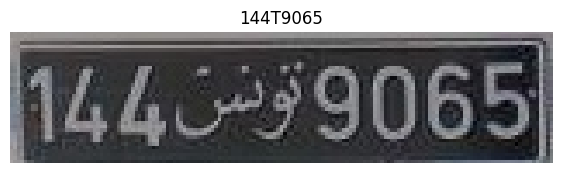

 22%|██▏       | 49/223 [00:13<00:34,  4.97it/s]

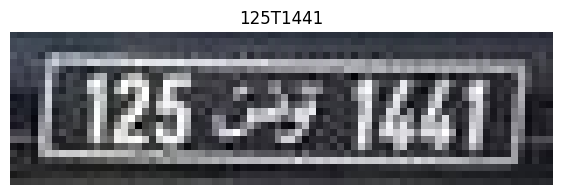

 22%|██▏       | 50/223 [00:13<00:34,  5.03it/s]

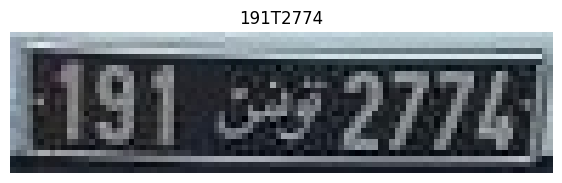

 23%|██▎       | 51/223 [00:14<00:36,  4.75it/s]

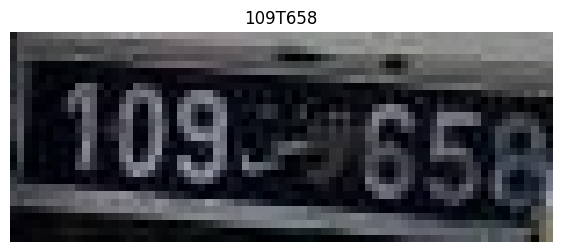

 23%|██▎       | 52/223 [00:14<00:36,  4.72it/s]

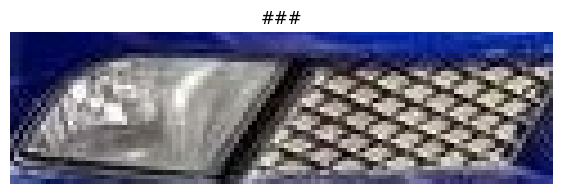

 24%|██▍       | 53/223 [00:14<00:35,  4.78it/s]

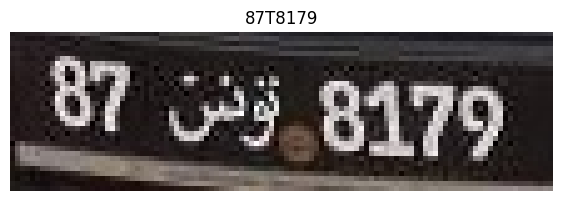

 24%|██▍       | 54/223 [00:14<00:34,  4.86it/s]

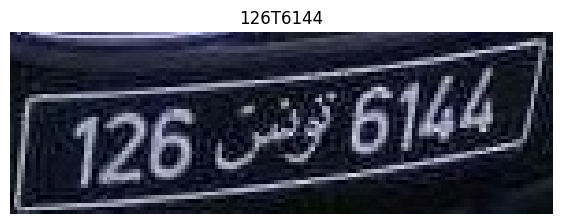

 25%|██▍       | 55/223 [00:14<00:35,  4.76it/s]

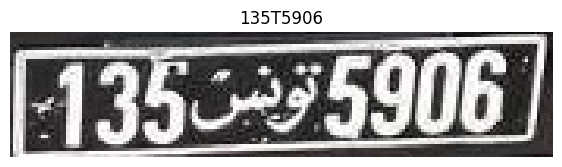

 25%|██▌       | 56/223 [00:15<00:35,  4.76it/s]

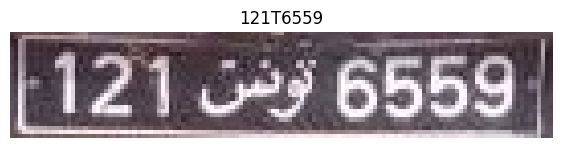

 26%|██▌       | 57/223 [00:15<00:34,  4.80it/s]

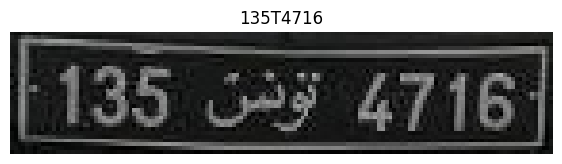

 26%|██▌       | 58/223 [00:15<00:34,  4.85it/s]

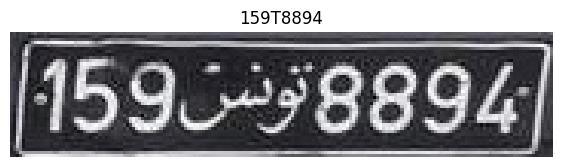

 26%|██▋       | 59/223 [00:15<00:33,  4.86it/s]

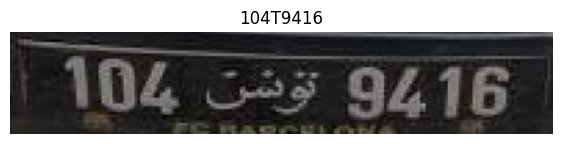

 27%|██▋       | 60/223 [00:15<00:35,  4.64it/s]

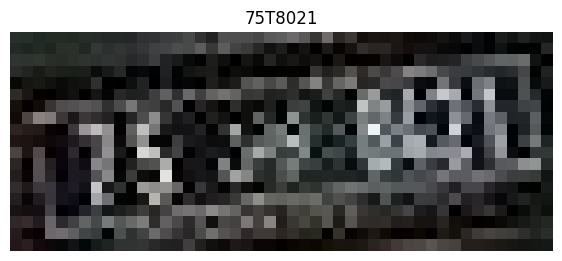

 27%|██▋       | 61/223 [00:16<00:35,  4.61it/s]

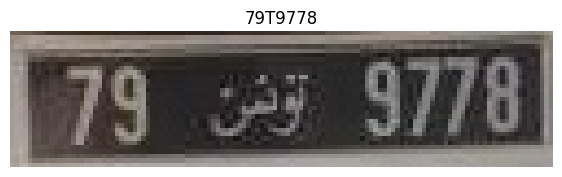

 28%|██▊       | 62/223 [00:16<00:34,  4.69it/s]

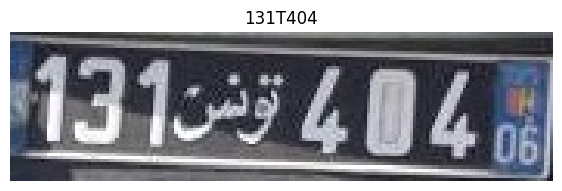

 28%|██▊       | 63/223 [00:16<00:34,  4.63it/s]

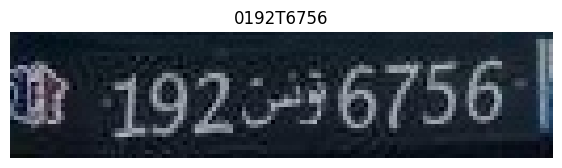

 29%|██▊       | 64/223 [00:16<00:32,  4.82it/s]

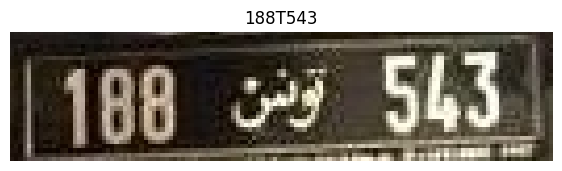

 29%|██▉       | 65/223 [00:17<00:32,  4.82it/s]

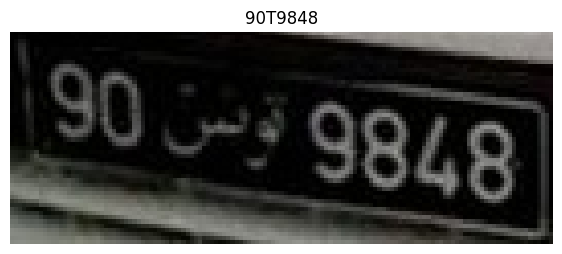

 30%|██▉       | 66/223 [00:17<00:33,  4.62it/s]

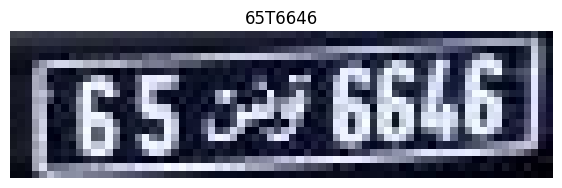

 30%|███       | 67/223 [00:17<00:34,  4.56it/s]

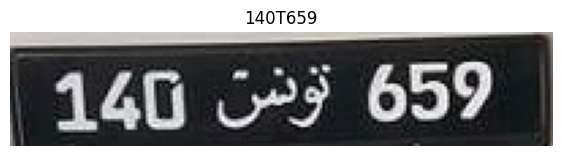

 30%|███       | 68/223 [00:17<00:34,  4.48it/s]

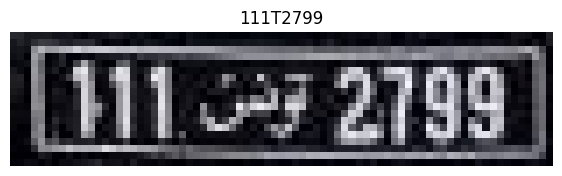

 31%|███       | 69/223 [00:17<00:33,  4.58it/s]

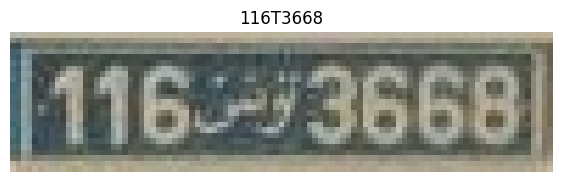

 31%|███▏      | 70/223 [00:18<00:39,  3.91it/s]

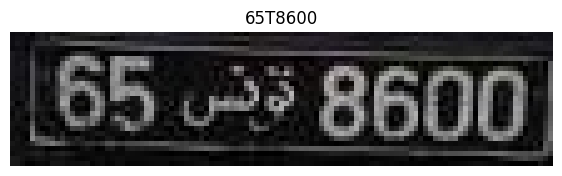

 32%|███▏      | 71/223 [00:18<00:40,  3.73it/s]

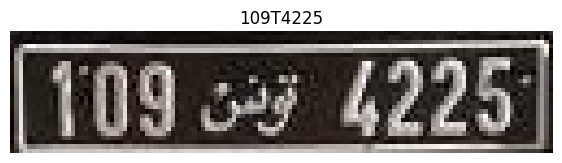

 32%|███▏      | 72/223 [00:18<00:41,  3.66it/s]

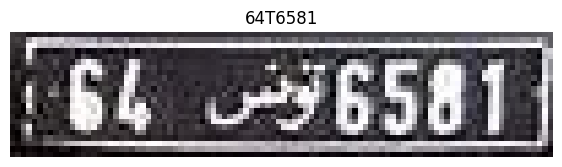

 33%|███▎      | 73/223 [00:19<00:40,  3.72it/s]

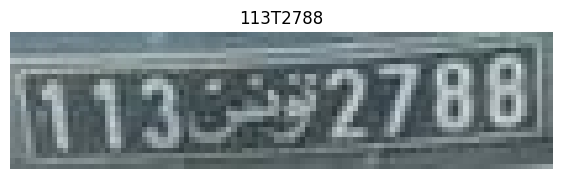

 33%|███▎      | 74/223 [00:19<00:40,  3.71it/s]

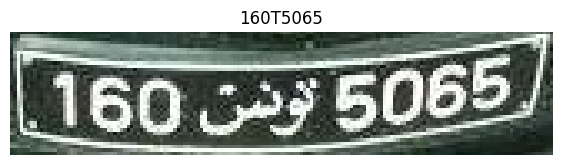

 34%|███▎      | 75/223 [00:19<00:41,  3.56it/s]

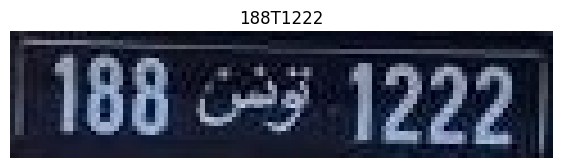

 34%|███▍      | 76/223 [00:19<00:38,  3.77it/s]

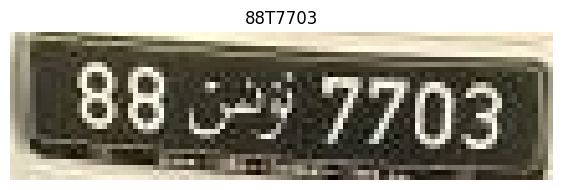

 35%|███▍      | 77/223 [00:20<00:37,  3.84it/s]

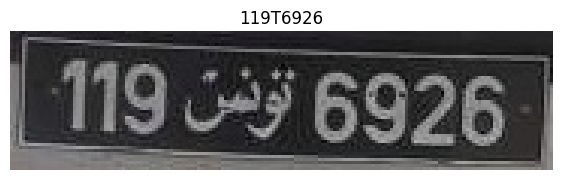

 35%|███▍      | 78/223 [00:20<00:38,  3.77it/s]

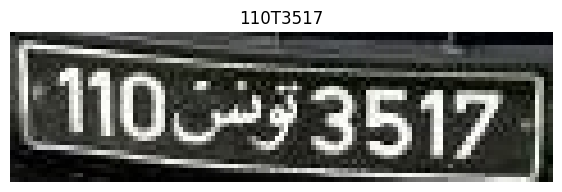

 35%|███▌      | 79/223 [00:20<00:41,  3.44it/s]

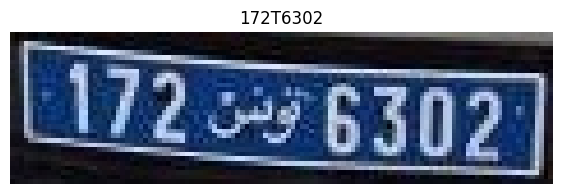

 36%|███▌      | 80/223 [00:21<00:40,  3.52it/s]

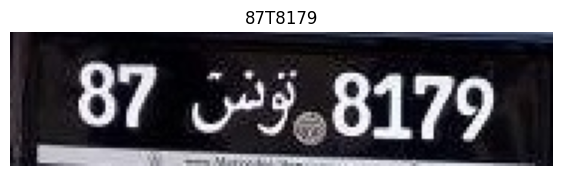

 36%|███▋      | 81/223 [00:21<00:40,  3.47it/s]

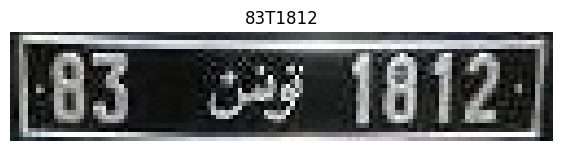

 37%|███▋      | 82/223 [00:21<00:39,  3.60it/s]

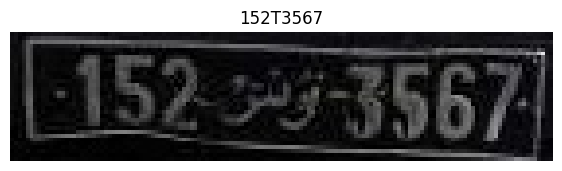

 37%|███▋      | 83/223 [00:21<00:38,  3.61it/s]

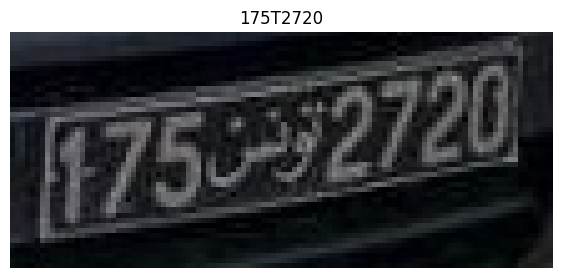

 38%|███▊      | 84/223 [00:22<00:41,  3.32it/s]

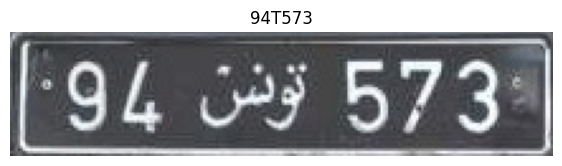

 38%|███▊      | 85/223 [00:22<00:41,  3.32it/s]

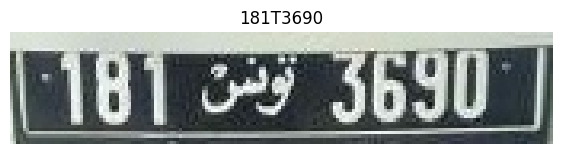

 39%|███▊      | 86/223 [00:22<00:42,  3.25it/s]

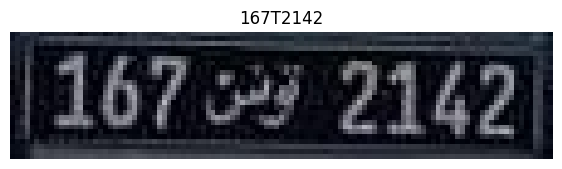

 39%|███▉      | 87/223 [00:23<00:40,  3.34it/s]

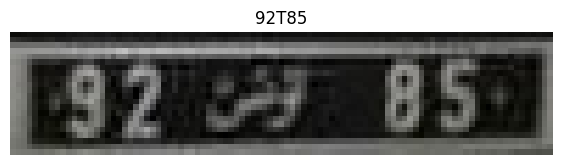

 39%|███▉      | 88/223 [00:23<00:40,  3.32it/s]

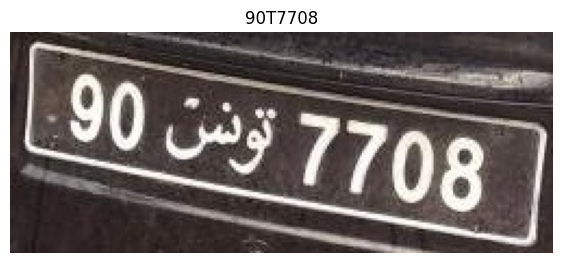

 40%|███▉      | 89/223 [00:23<00:42,  3.18it/s]

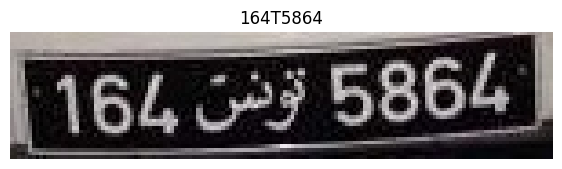

 40%|████      | 90/223 [00:24<00:39,  3.39it/s]

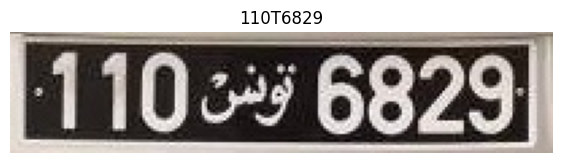

 41%|████      | 91/223 [00:24<00:45,  2.93it/s]

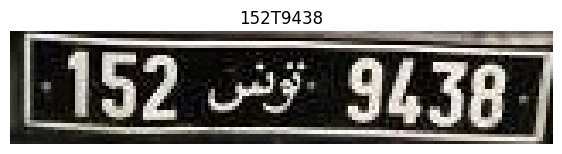

 41%|████▏     | 92/223 [00:24<00:45,  2.90it/s]

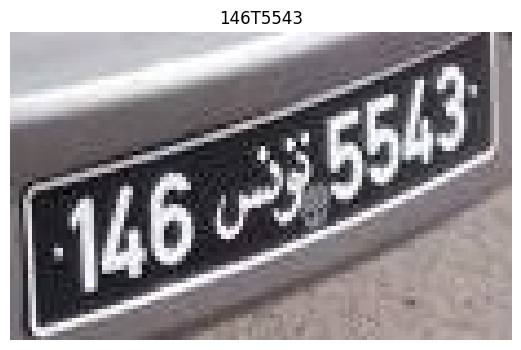

 42%|████▏     | 93/223 [00:25<00:41,  3.16it/s]

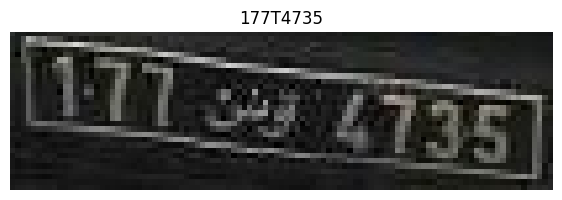

 42%|████▏     | 94/223 [00:25<00:36,  3.56it/s]

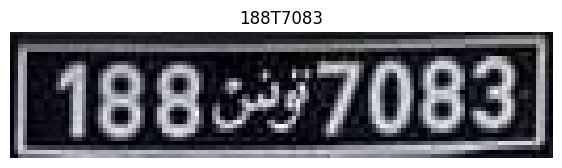

 43%|████▎     | 95/223 [00:25<00:32,  3.89it/s]

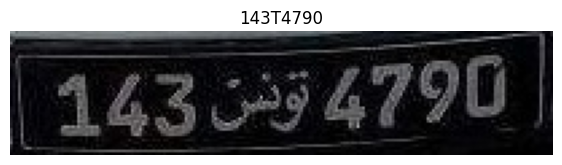

 43%|████▎     | 96/223 [00:25<00:32,  3.94it/s]

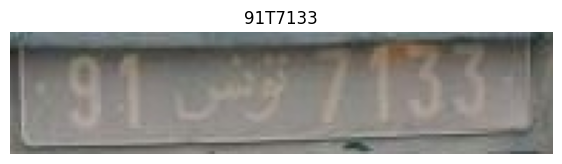

 43%|████▎     | 97/223 [00:25<00:31,  3.99it/s]

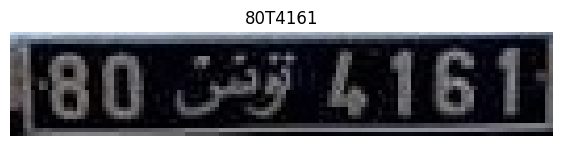

 44%|████▍     | 98/223 [00:26<00:30,  4.10it/s]

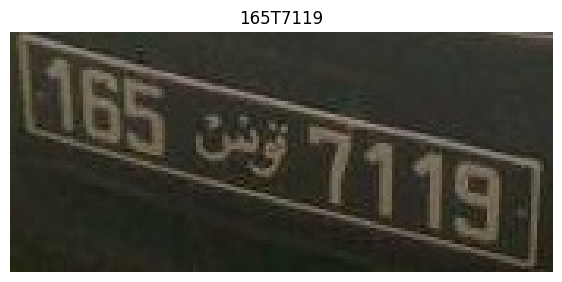

 44%|████▍     | 99/223 [00:26<00:29,  4.20it/s]

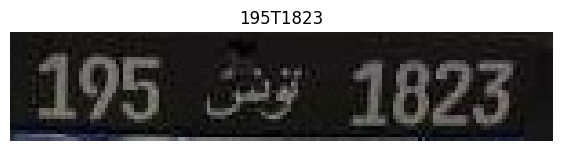

 45%|████▍     | 100/223 [00:26<00:27,  4.45it/s]

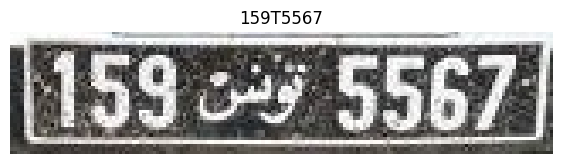

 45%|████▌     | 101/223 [00:26<00:26,  4.56it/s]

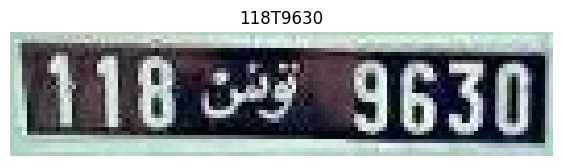

 46%|████▌     | 102/223 [00:27<00:25,  4.68it/s]

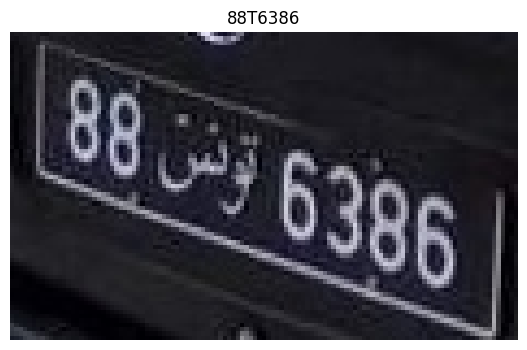

 46%|████▌     | 103/223 [00:27<00:27,  4.42it/s]

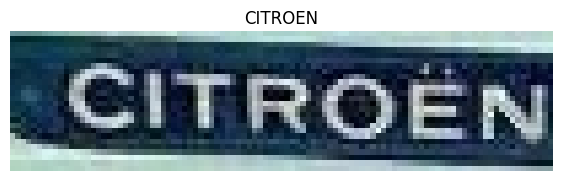

 47%|████▋     | 104/223 [00:27<00:26,  4.43it/s]

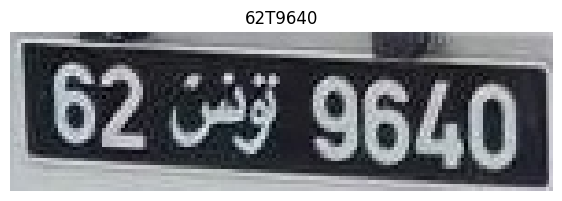

 47%|████▋     | 105/223 [00:27<00:26,  4.52it/s]

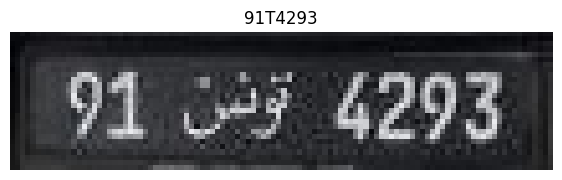

 48%|████▊     | 106/223 [00:27<00:25,  4.60it/s]

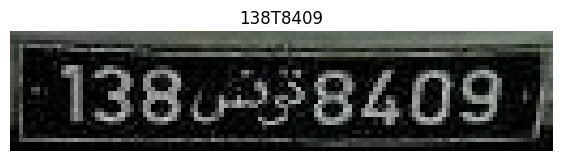

 48%|████▊     | 107/223 [00:28<00:25,  4.60it/s]

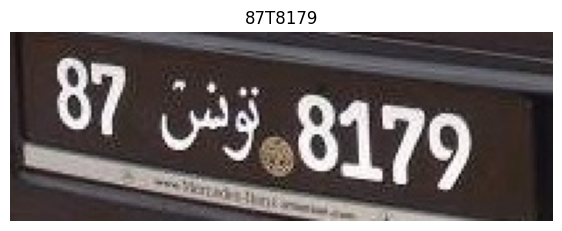

 48%|████▊     | 108/223 [00:28<00:26,  4.33it/s]

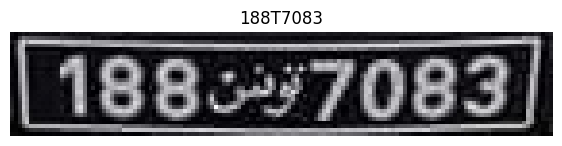

 49%|████▉     | 109/223 [00:28<00:24,  4.61it/s]

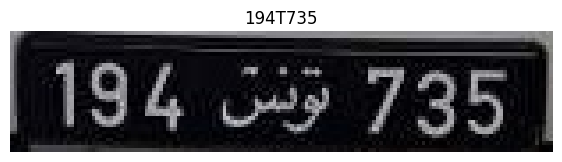

 49%|████▉     | 110/223 [00:28<00:24,  4.54it/s]

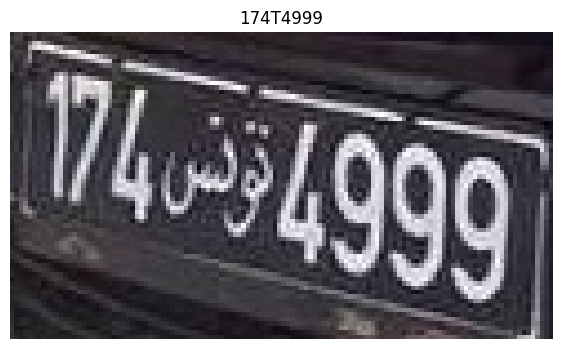

 50%|████▉     | 111/223 [00:29<00:25,  4.42it/s]

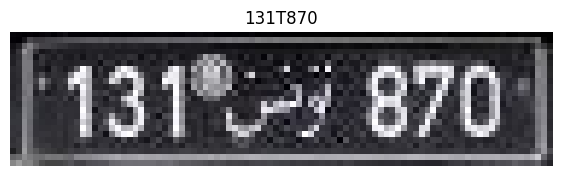

 50%|█████     | 112/223 [00:29<00:24,  4.54it/s]

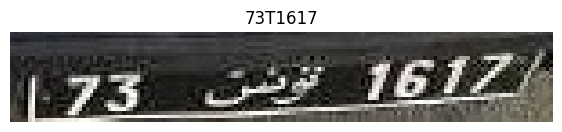

 51%|█████     | 113/223 [00:29<00:23,  4.74it/s]

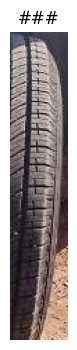

 51%|█████     | 114/223 [00:29<00:23,  4.73it/s]

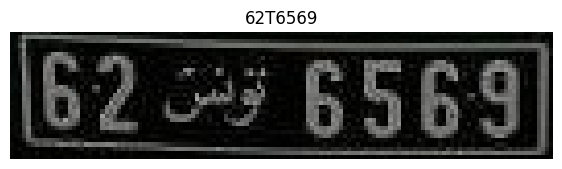

 52%|█████▏    | 115/223 [00:29<00:23,  4.53it/s]

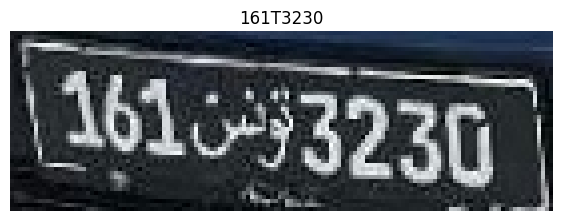

 52%|█████▏    | 116/223 [00:30<00:24,  4.41it/s]

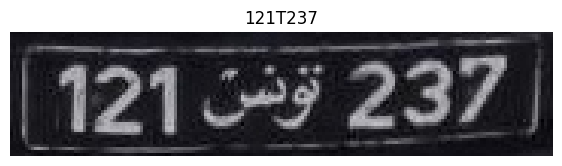

 52%|█████▏    | 117/223 [00:30<00:22,  4.68it/s]

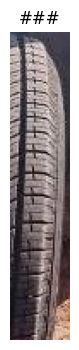

 53%|█████▎    | 118/223 [00:30<00:23,  4.55it/s]

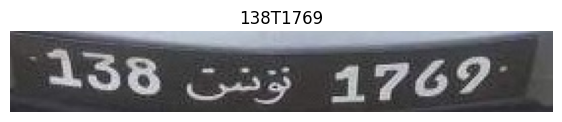

 53%|█████▎    | 119/223 [00:30<00:22,  4.62it/s]

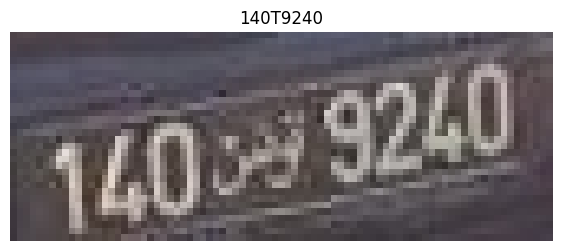

 54%|█████▍    | 120/223 [00:31<00:22,  4.53it/s]

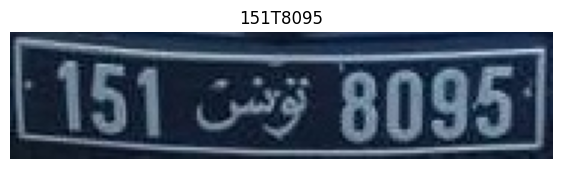

 54%|█████▍    | 121/223 [00:31<00:24,  4.23it/s]

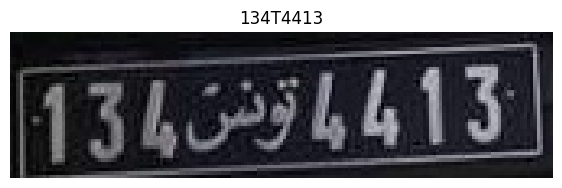

 55%|█████▍    | 122/223 [00:31<00:23,  4.39it/s]

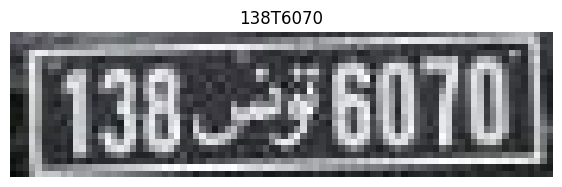

 55%|█████▌    | 123/223 [00:31<00:22,  4.46it/s]

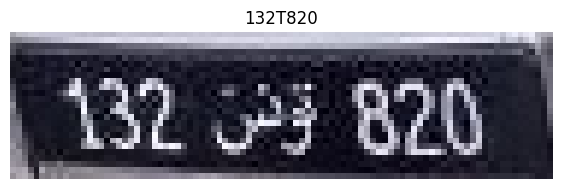

 56%|█████▌    | 124/223 [00:31<00:22,  4.47it/s]

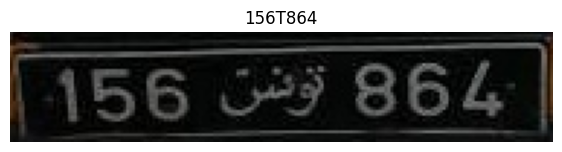

 56%|█████▌    | 125/223 [00:32<00:22,  4.45it/s]

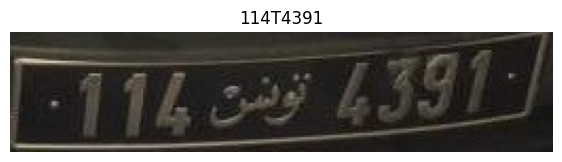

 57%|█████▋    | 126/223 [00:32<00:22,  4.32it/s]

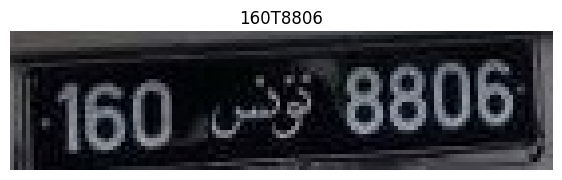

 57%|█████▋    | 127/223 [00:32<00:21,  4.41it/s]

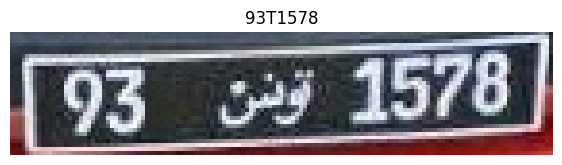

 57%|█████▋    | 128/223 [00:32<00:20,  4.52it/s]

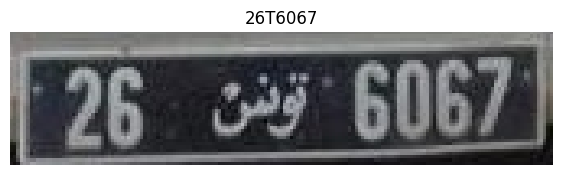

 58%|█████▊    | 129/223 [00:33<00:20,  4.55it/s]

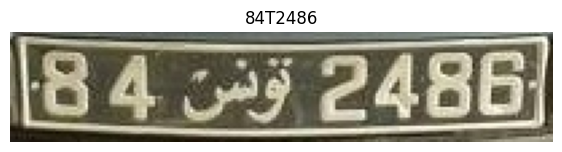

 58%|█████▊    | 130/223 [00:33<00:21,  4.27it/s]

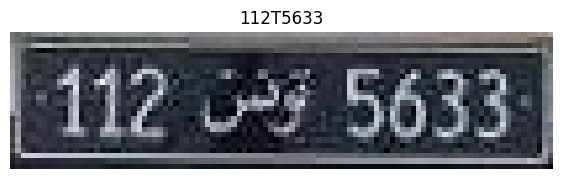

 59%|█████▊    | 131/223 [00:33<00:20,  4.47it/s]

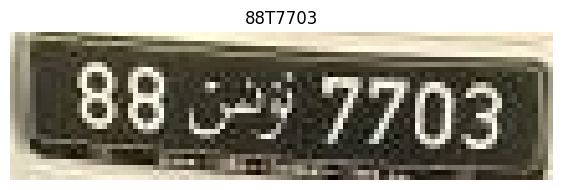

 59%|█████▉    | 132/223 [00:33<00:20,  4.46it/s]

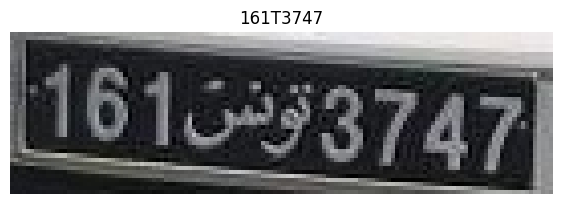

 60%|█████▉    | 133/223 [00:33<00:20,  4.33it/s]

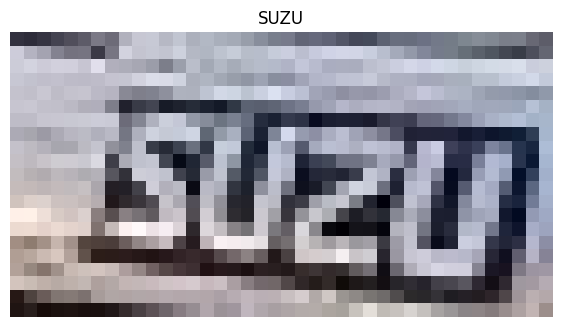

 60%|██████    | 134/223 [00:34<00:24,  3.71it/s]

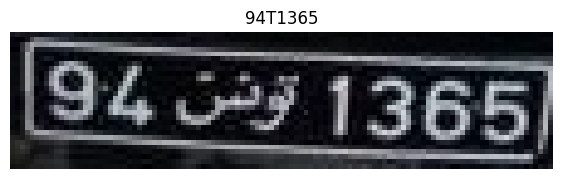

 61%|██████    | 135/223 [00:34<00:24,  3.64it/s]

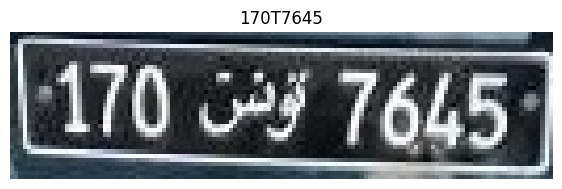

 61%|██████    | 136/223 [00:34<00:24,  3.57it/s]

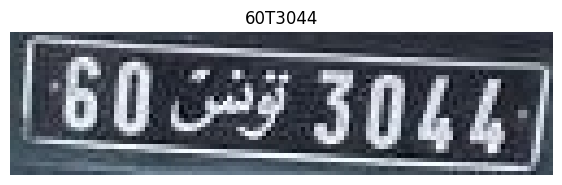

 61%|██████▏   | 137/223 [00:35<00:24,  3.50it/s]

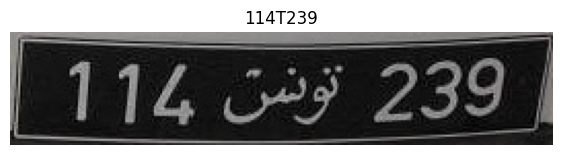

 62%|██████▏   | 138/223 [00:35<00:25,  3.39it/s]

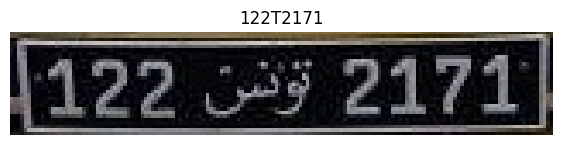

 62%|██████▏   | 139/223 [00:35<00:24,  3.43it/s]

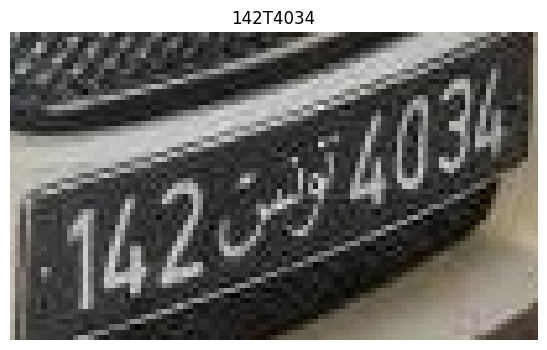

 63%|██████▎   | 140/223 [00:36<00:25,  3.31it/s]

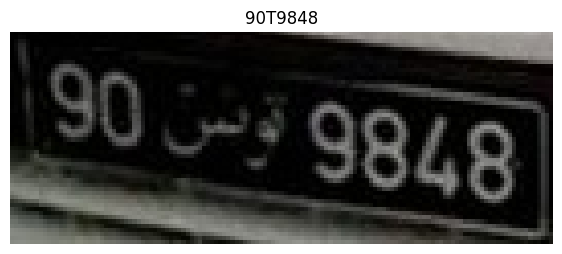

 63%|██████▎   | 141/223 [00:36<00:24,  3.33it/s]

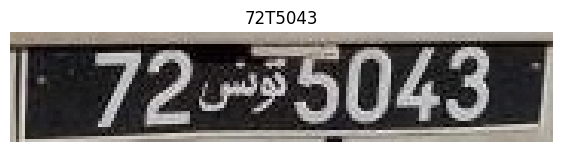

 64%|██████▎   | 142/223 [00:36<00:23,  3.42it/s]

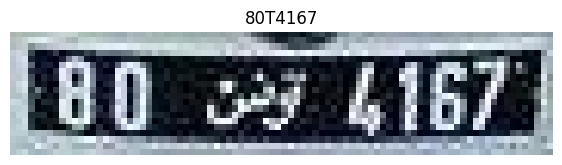

 64%|██████▍   | 143/223 [00:37<00:23,  3.43it/s]

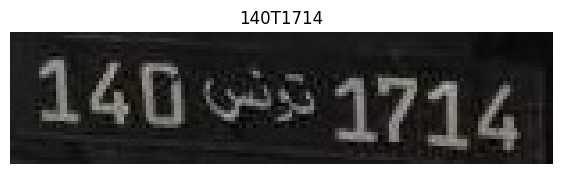

 65%|██████▍   | 144/223 [00:37<00:22,  3.46it/s]

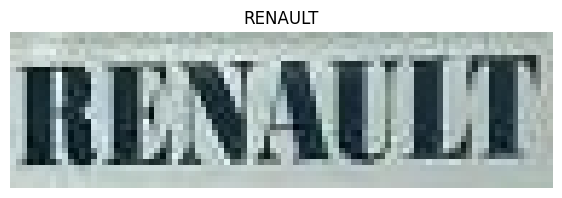

 65%|██████▌   | 145/223 [00:37<00:21,  3.63it/s]

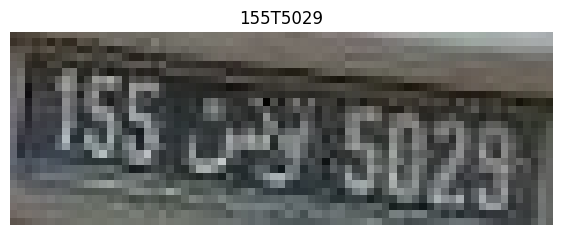

 65%|██████▌   | 146/223 [00:38<00:33,  2.27it/s]

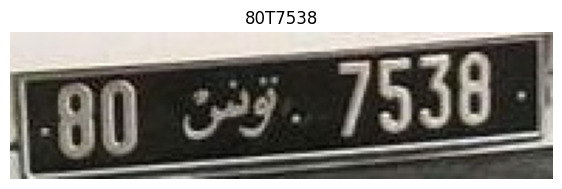

 66%|██████▌   | 147/223 [00:38<00:31,  2.43it/s]

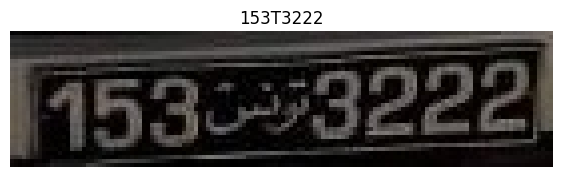

 66%|██████▋   | 148/223 [00:38<00:27,  2.74it/s]

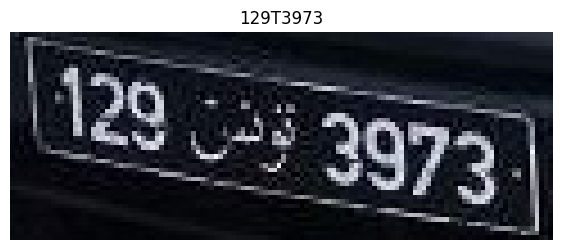

 67%|██████▋   | 149/223 [00:39<00:25,  2.91it/s]

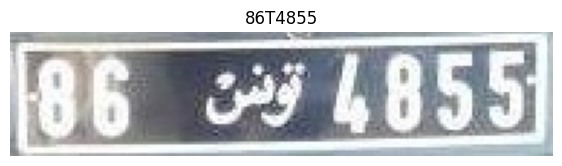

 67%|██████▋   | 150/223 [00:39<00:24,  3.02it/s]

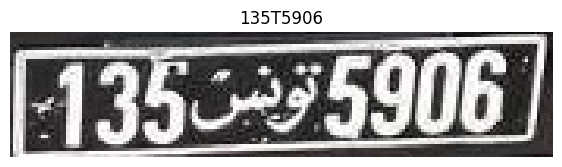

 68%|██████▊   | 151/223 [00:39<00:22,  3.17it/s]

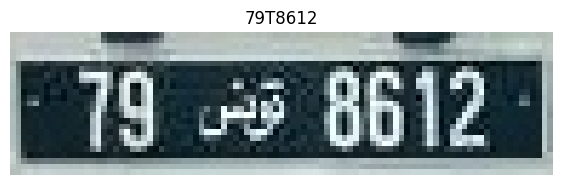

 68%|██████▊   | 152/223 [00:40<00:22,  3.20it/s]

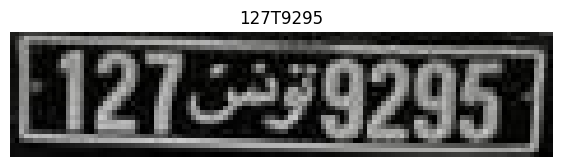

 69%|██████▊   | 153/223 [00:40<00:21,  3.32it/s]

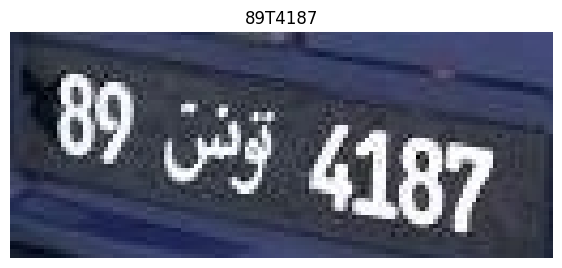

 69%|██████▉   | 154/223 [00:40<00:21,  3.16it/s]

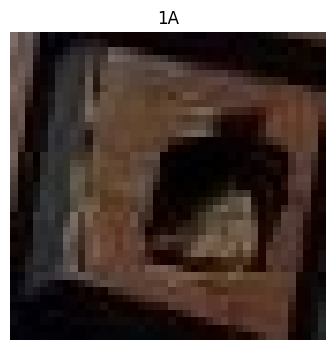

 70%|██████▉   | 155/223 [00:41<00:20,  3.27it/s]

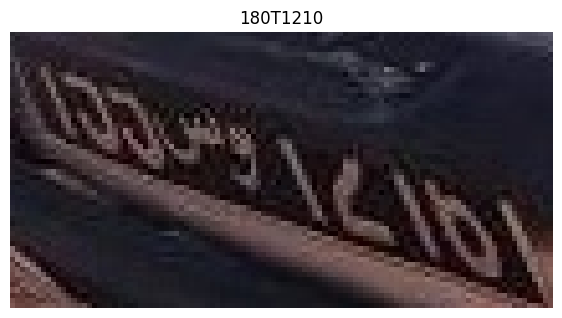

 70%|██████▉   | 156/223 [00:41<00:19,  3.40it/s]

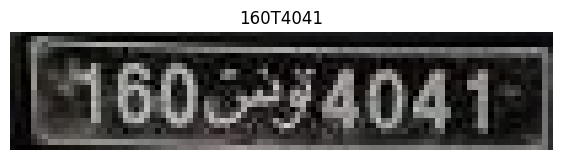

 70%|███████   | 157/223 [00:41<00:17,  3.67it/s]

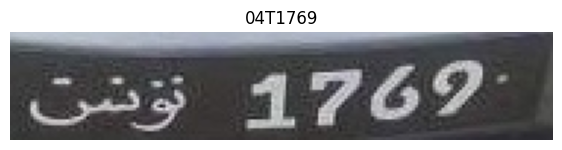

 71%|███████   | 158/223 [00:41<00:17,  3.82it/s]

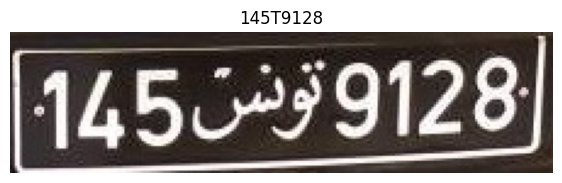

 71%|███████▏  | 159/223 [00:42<00:16,  3.78it/s]

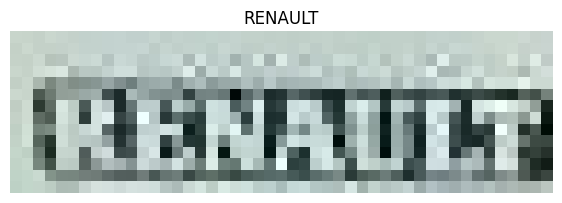

 72%|███████▏  | 160/223 [00:42<00:15,  3.95it/s]

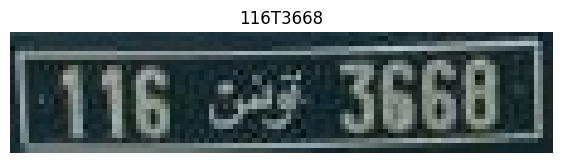

 72%|███████▏  | 161/223 [00:42<00:15,  4.06it/s]

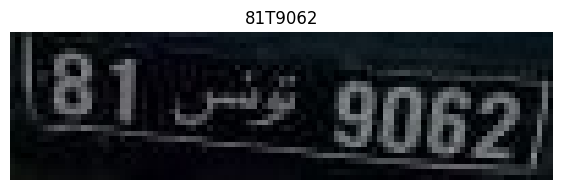

 73%|███████▎  | 162/223 [00:42<00:14,  4.14it/s]

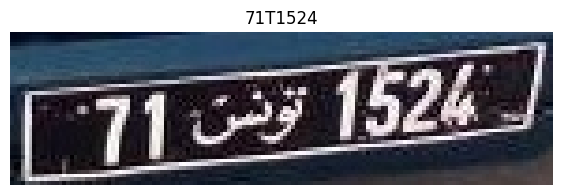

 73%|███████▎  | 163/223 [00:42<00:14,  4.17it/s]

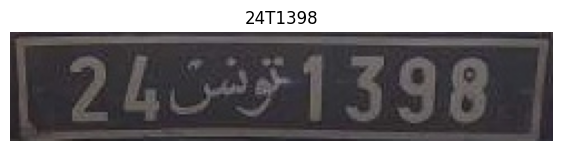

 74%|███████▎  | 164/223 [00:43<00:14,  4.08it/s]

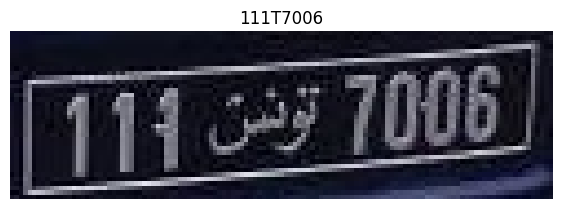

 74%|███████▍  | 165/223 [00:43<00:13,  4.16it/s]

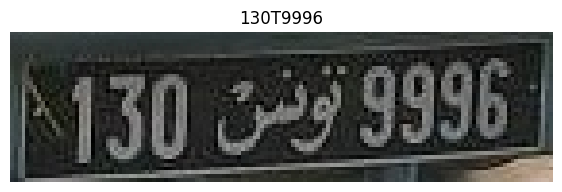

 74%|███████▍  | 166/223 [00:43<00:14,  4.06it/s]

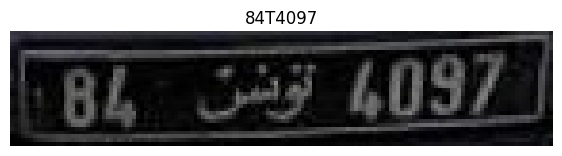

 75%|███████▍  | 167/223 [00:43<00:13,  4.18it/s]

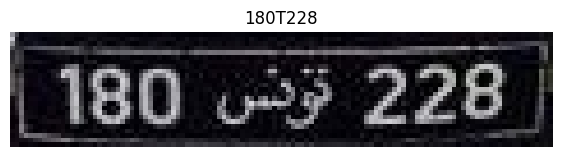

 75%|███████▌  | 168/223 [00:44<00:12,  4.24it/s]

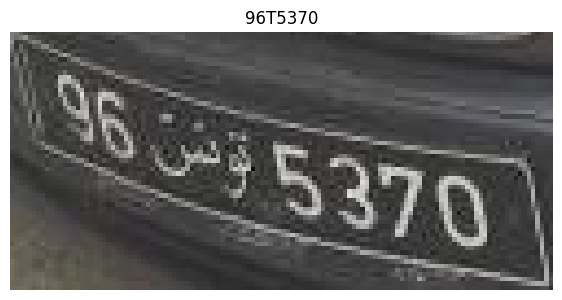

 76%|███████▌  | 169/223 [00:44<00:13,  4.11it/s]

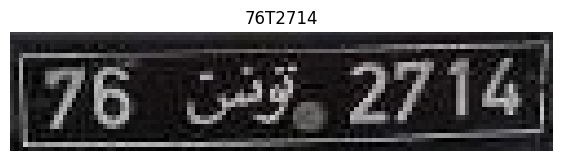

 76%|███████▌  | 170/223 [00:44<00:12,  4.19it/s]

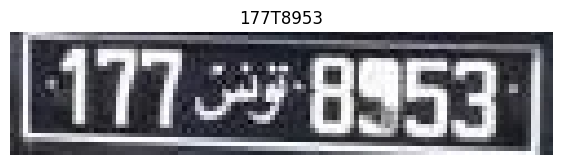

 77%|███████▋  | 171/223 [00:44<00:12,  4.26it/s]

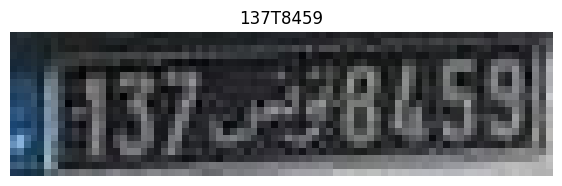

 77%|███████▋  | 172/223 [00:45<00:11,  4.30it/s]

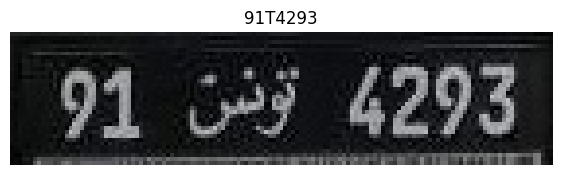

 78%|███████▊  | 173/223 [00:45<00:11,  4.20it/s]

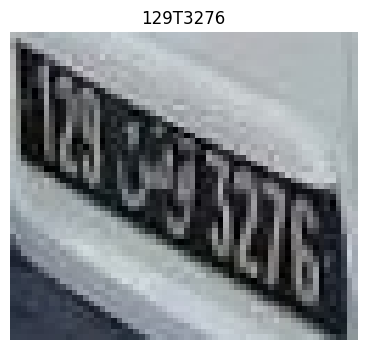

 78%|███████▊  | 174/223 [00:45<00:13,  3.75it/s]

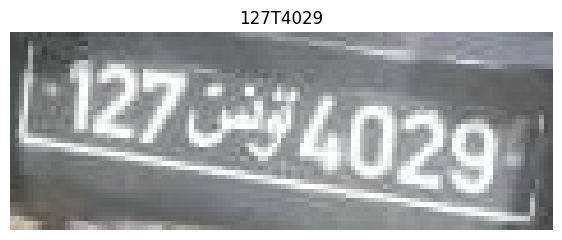

 78%|███████▊  | 175/223 [00:46<00:15,  3.10it/s]

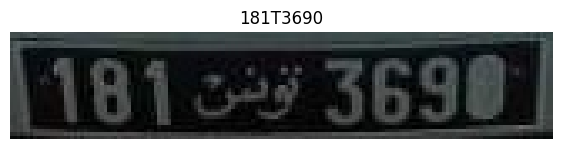

 79%|███████▉  | 176/223 [00:46<00:16,  2.88it/s]

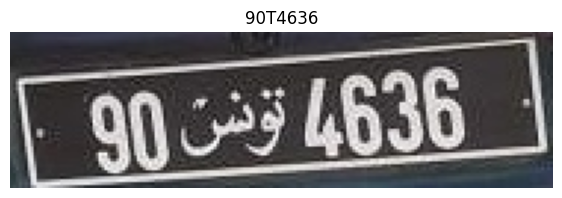

 79%|███████▉  | 177/223 [00:47<00:17,  2.60it/s]

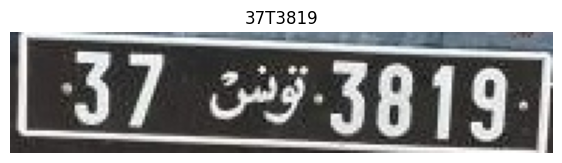

 80%|███████▉  | 178/223 [00:47<00:16,  2.67it/s]

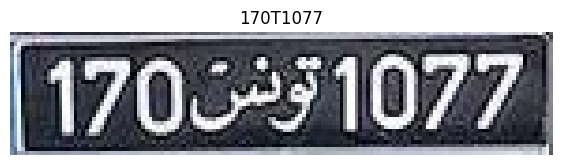

 80%|████████  | 179/223 [00:47<00:16,  2.66it/s]

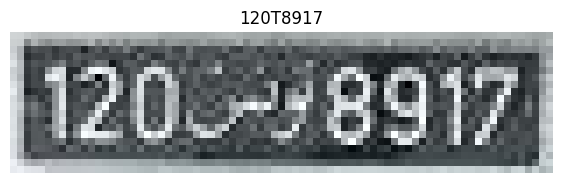

 81%|████████  | 180/223 [00:48<00:14,  2.94it/s]

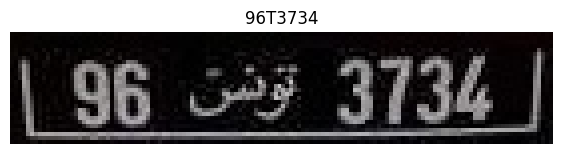

 81%|████████  | 181/223 [00:48<00:15,  2.69it/s]

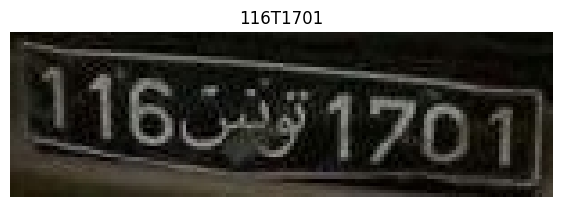

 82%|████████▏ | 182/223 [00:48<00:16,  2.49it/s]

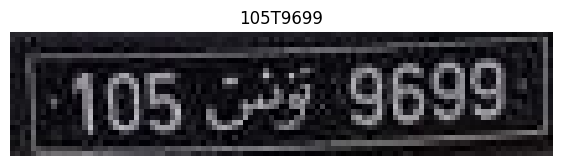

 82%|████████▏ | 183/223 [00:49<00:17,  2.32it/s]

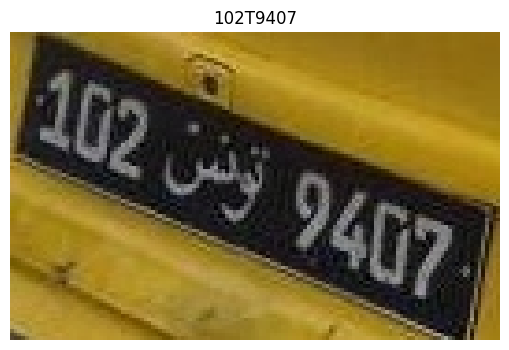

 83%|████████▎ | 184/223 [00:50<00:18,  2.07it/s]

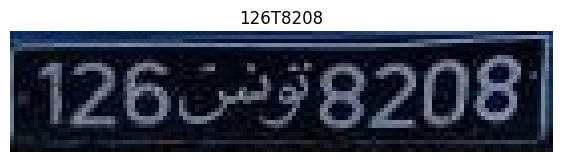

 83%|████████▎ | 185/223 [00:50<00:17,  2.20it/s]

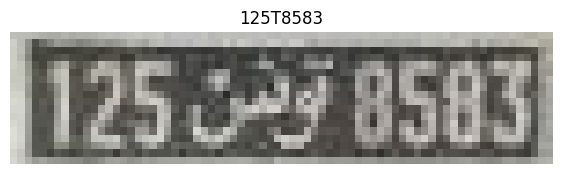

 83%|████████▎ | 186/223 [00:50<00:14,  2.49it/s]

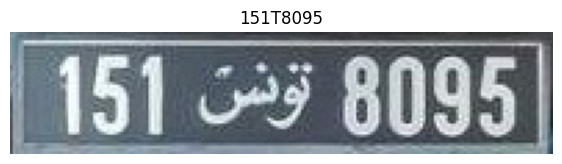

 84%|████████▍ | 187/223 [00:51<00:14,  2.49it/s]

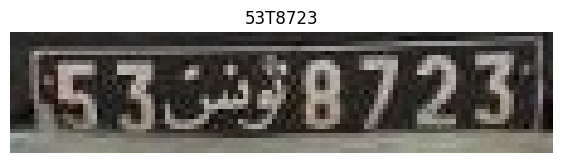

 84%|████████▍ | 188/223 [00:51<00:13,  2.52it/s]

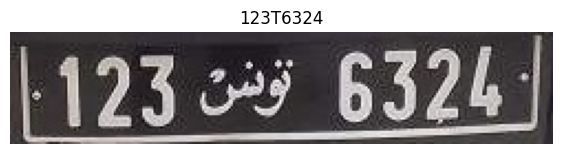

 85%|████████▍ | 189/223 [00:51<00:14,  2.41it/s]

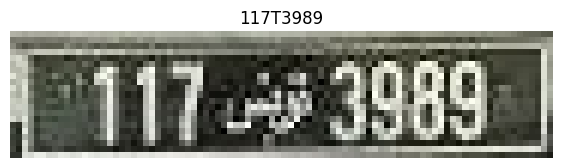

 85%|████████▌ | 190/223 [00:52<00:14,  2.34it/s]

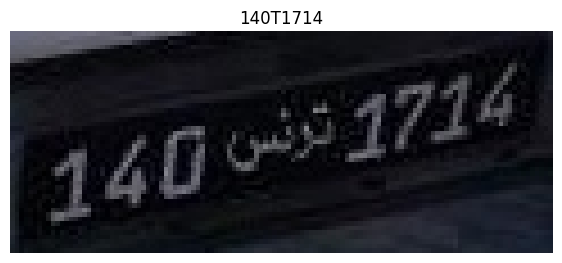

 86%|████████▌ | 191/223 [00:52<00:13,  2.32it/s]

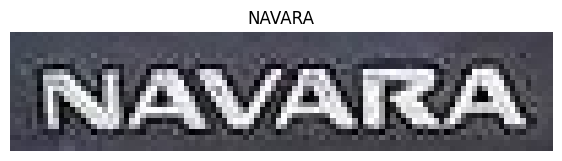

 86%|████████▌ | 192/223 [00:53<00:13,  2.27it/s]

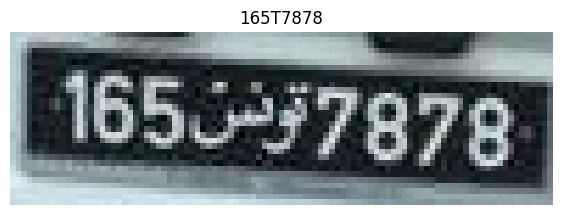

 87%|████████▋ | 193/223 [00:53<00:13,  2.26it/s]

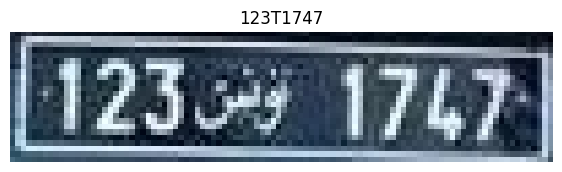

 87%|████████▋ | 194/223 [00:54<00:12,  2.29it/s]

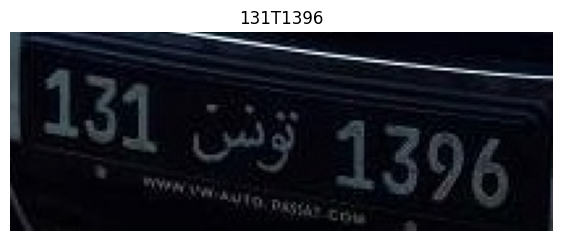

 87%|████████▋ | 195/223 [00:54<00:13,  2.08it/s]

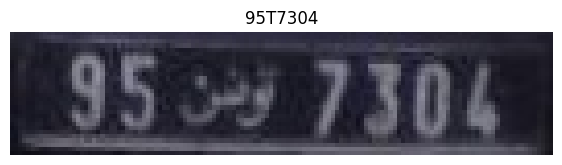

 88%|████████▊ | 196/223 [00:55<00:12,  2.22it/s]

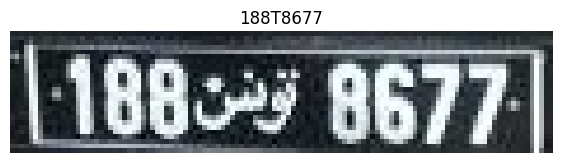

 88%|████████▊ | 197/223 [00:55<00:11,  2.26it/s]

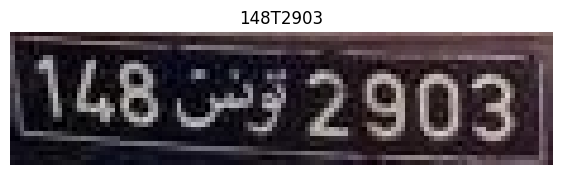

 89%|████████▉ | 198/223 [00:55<00:10,  2.29it/s]

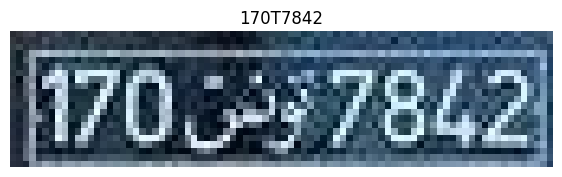

 89%|████████▉ | 199/223 [00:56<00:11,  2.06it/s]

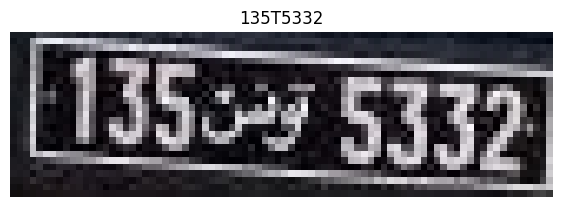

 90%|████████▉ | 200/223 [00:57<00:13,  1.75it/s]

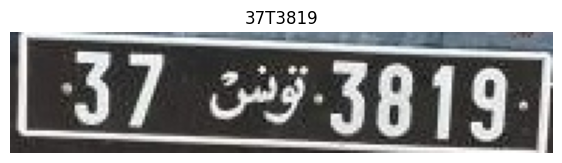

 90%|█████████ | 201/223 [00:58<00:14,  1.49it/s]

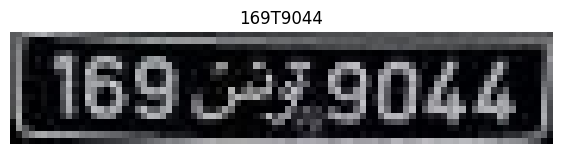

 91%|█████████ | 202/223 [00:58<00:13,  1.59it/s]

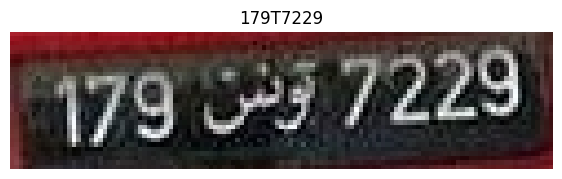

 91%|█████████ | 203/223 [00:59<00:11,  1.74it/s]

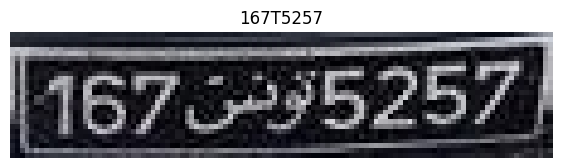

 91%|█████████▏| 204/223 [00:59<00:09,  1.98it/s]

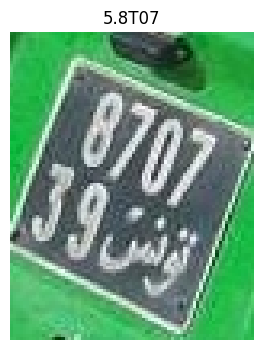

 92%|█████████▏| 205/223 [00:59<00:07,  2.28it/s]

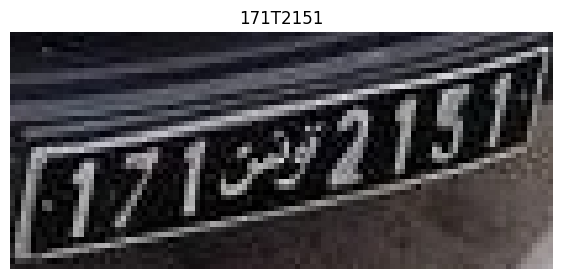

 92%|█████████▏| 206/223 [01:00<00:07,  2.43it/s]

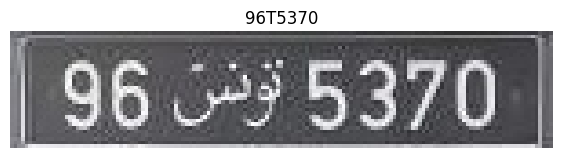

 93%|█████████▎| 207/223 [01:00<00:06,  2.64it/s]

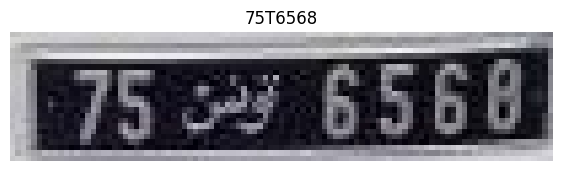

 93%|█████████▎| 208/223 [01:00<00:05,  2.73it/s]

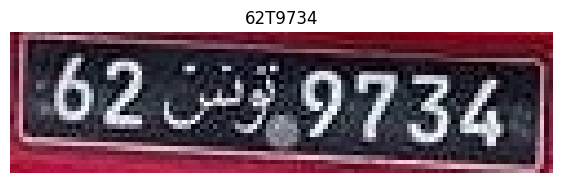

 94%|█████████▎| 209/223 [01:01<00:05,  2.67it/s]

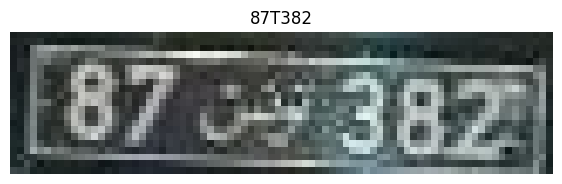

 94%|█████████▍| 210/223 [01:01<00:05,  2.55it/s]

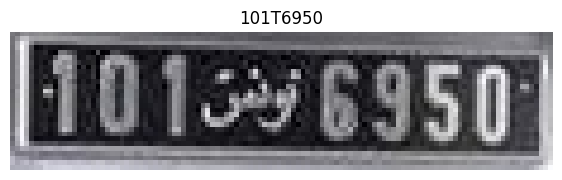

 95%|█████████▍| 211/223 [01:02<00:04,  2.49it/s]

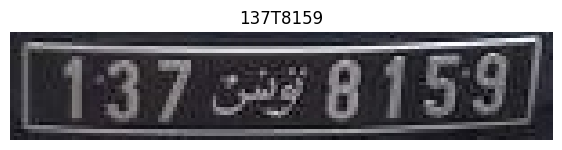

 95%|█████████▌| 212/223 [01:02<00:05,  2.18it/s]

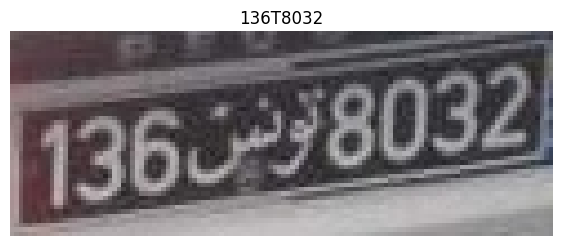

 96%|█████████▌| 213/223 [01:03<00:05,  1.97it/s]

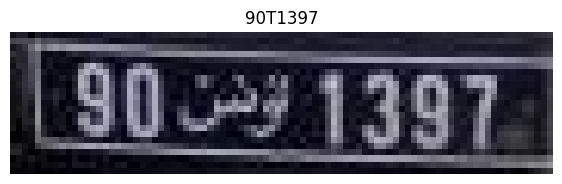

 96%|█████████▌| 214/223 [01:03<00:04,  2.00it/s]

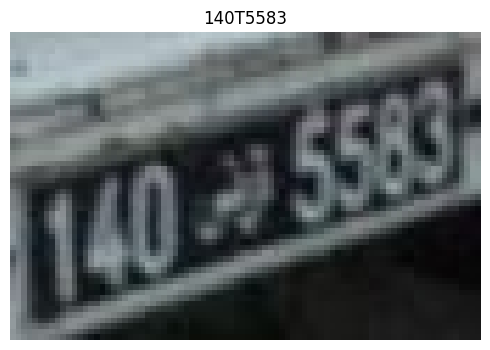

 96%|█████████▋| 215/223 [01:04<00:03,  2.22it/s]

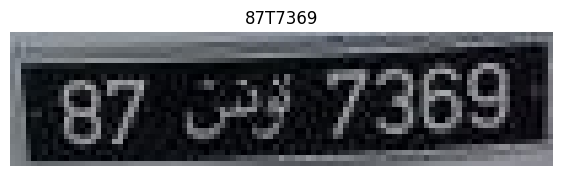

 97%|█████████▋| 216/223 [01:04<00:02,  2.44it/s]

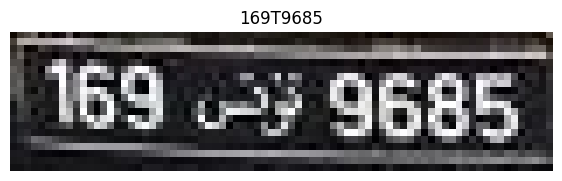

 97%|█████████▋| 217/223 [01:04<00:02,  2.61it/s]

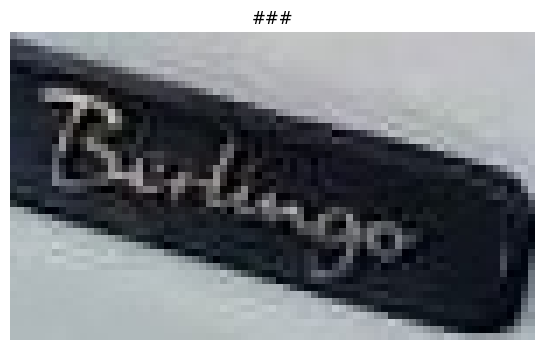

 98%|█████████▊| 218/223 [01:05<00:02,  2.40it/s]

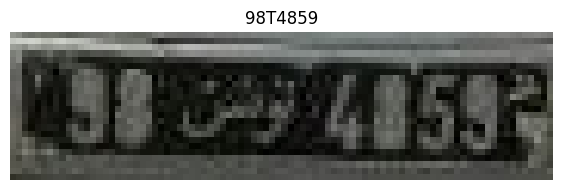

 98%|█████████▊| 219/223 [01:05<00:01,  2.23it/s]

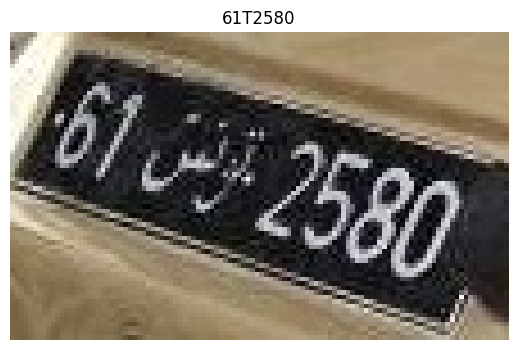

 99%|█████████▊| 220/223 [01:06<00:01,  2.19it/s]

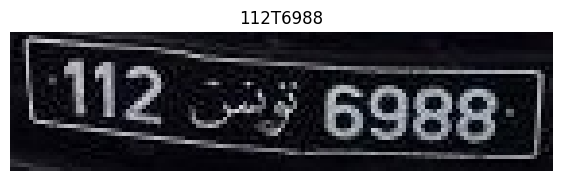

 99%|█████████▉| 221/223 [01:06<00:00,  2.48it/s]

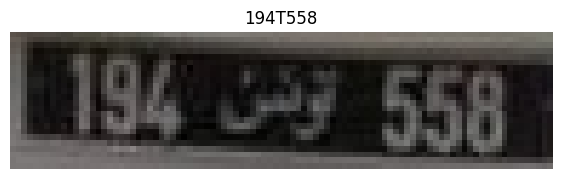

100%|█████████▉| 222/223 [01:06<00:00,  2.54it/s]

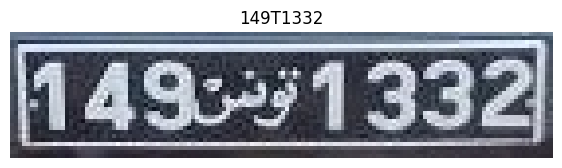

100%|██████████| 223/223 [01:07<00:00,  3.32it/s]


In [9]:
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'cropped_images', '*'),
    num_samples=223
)